# Mosquito Species Classification Using Neural Networks

Authors: Pratik Mulchandani, Muhammad Umair Siddiqui

Dataset: https://www.kaggle.com/potamitis/wingbeats

According to the World Health Organization, diseases such as malaria and dengue account for almost one million deaths every year. Carrier mosquitoes for a particular disease remain exclusive to it. A majority of carrier mosquitoes spread the disease throughout a region by reproducing in it. With advancements Machine Learning and Computer Vision technologies, the species of mosquitoes in a particular region can be easily and swiftly detected using recordings of their wing movements. The wing beats of a particular mosquito species are unique, making this a reliable method to identify them. Once these solutions are deployed on mosquito traps, a particular region can be alerted if, for example, an Aedes Aegypti mosquito is found. This mosquito species is widely known to carry the Zika virus. The identification of such carrier species can also help in detecting the spread of mosquito-borne diseases in the surveyed region. We go through various techniques which show promising results in the identification of mosquito species. The trained models can be deployed on constrained devices to make a cost-effective and efficient mosquito species identification system.

# Import required libraries

In [1]:
import PIL
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import IPython
import matplotlib.pyplot as plt
from matplotlib.pyplot import specgram
import librosa
import librosa.display
import numpy as np
import os
import glob
import shutil
from pathlib import Path
from fastai.imports import *
from fastai import *
from fastai.vision import *

All audio samples are 4 seconds long which fits well with our spectrogram method.

# Process the data and create spectrograms

In [4]:
labels  = ['Ae. aegypti','Ae. albopictus','An. arabiensis',
           'An. gambiae','C. pipiens','C. quinquefasciatus']

In [5]:
#labelpath=['Wingbeats/Ae. aegypti/','Wingbeats/Ae. albopictus/','Wingbeats/An. arabiensis/','Wingbeats/An. gambiae/','Wingbeats/C. pipiens/','Wingbeats/C. quinquefasciatus/']
labelpath=['Wingbeats/C. quinquefasciatus/']
spectrogram_path = Path('Wingbeats/data/train/C. quinquefasciatus/')  
for i in labelpath:
    audio_path = Path(i)  
    for audio_file in list(audio_path.glob('*.wav')):
        samples, sample_rate = librosa.load(audio_file)
        fig = plt.figure(figsize=[0.72,0.72])
        ax = fig.add_subplot(111)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        ax.set_frame_on(False)
        filename  = spectrogram_path/Path(audio_file).name.replace('.wav','.png')
        S = librosa.feature.melspectrogram(y=samples, sr=sample_rate)
        librosa.display.specshow(librosa.power_to_db(S, ref=np.max))
        plt.savefig(filename, dpi=400, bbox_inches='tight',pad_inches=0)
        plt.close('all')
    print(i)

Delete corrupted files

In [6]:
labels  = ['Ae. aegypti','Ae. albopictus','An. arabiensis',
           'An. gambiae','C. pipiens','C. quinquefasciatus']
paths=['test','train','valid']
data_path2 = Path('Wingbeats/data')  
for i in range(3):
    for j in range(6):
        print(paths[i]+' '+labels[j])
        png_files =  list(Path(data_path2/paths[i]/labels[j]).glob('*.png'))
        for file in png_files:
            try:
                img = Image.open(file)
                img.verify()
                img.close()
                img = Image.open(file)
                img.load()
                img.close()
                
            except(IOError, OSError, SyntaxError) as e:
                print(file)

test Ae. aegypti
test Ae. albopictus
test An. arabiensis
test An. gambiae
test C. pipiens
test C. quinquefasciatus
train Ae. aegypti


KeyboardInterrupt: 

In [6]:
data_path2 = Path('Wingbeats/data/Ae. aegypti/') 
data_path = Path('Wingbeats/Ae. aegypti/') 
spectrogram_path = Path('Wingbeats/spectrogram/')  
def arrange_data():
    png_files =  list(Path(spectrogram_path).glob('*.png'))
    wav_files = list(Path(data_path).glob('*.wav'))
    for file in png_files:
        filename  = file.name.replace('.png','.wav')
        if filename in wav_files:
            shutil.copyfile(file, data_path2/file.name)  

In [ ]:
arrange_data()

First let's take a look at some of the spectrograms

In [7]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [8]:
data_directory = Path('Wingbeats/spectrogram/')
data = ImageDataBunch.from_folder(data_directory, ds_tfms=[], size=224)
data.normalize(imagenet_stats)    

ImageDataBunch;

Train: LabelList
y: CategoryList (191555 items)
[Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti]...
Path: spectro\data2
x: ImageItemList (191555 items)
[Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230)]...
Path: spectro\data2;

Valid: LabelList
y: CategoryList (2080 items)
[Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti, Category Ae. aegypti]...
Path: spectro\data2
x: ImageItemList (2080 items)
[Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230), Image (3, 224, 230)]...
Path: spectro\data2;

Test: None

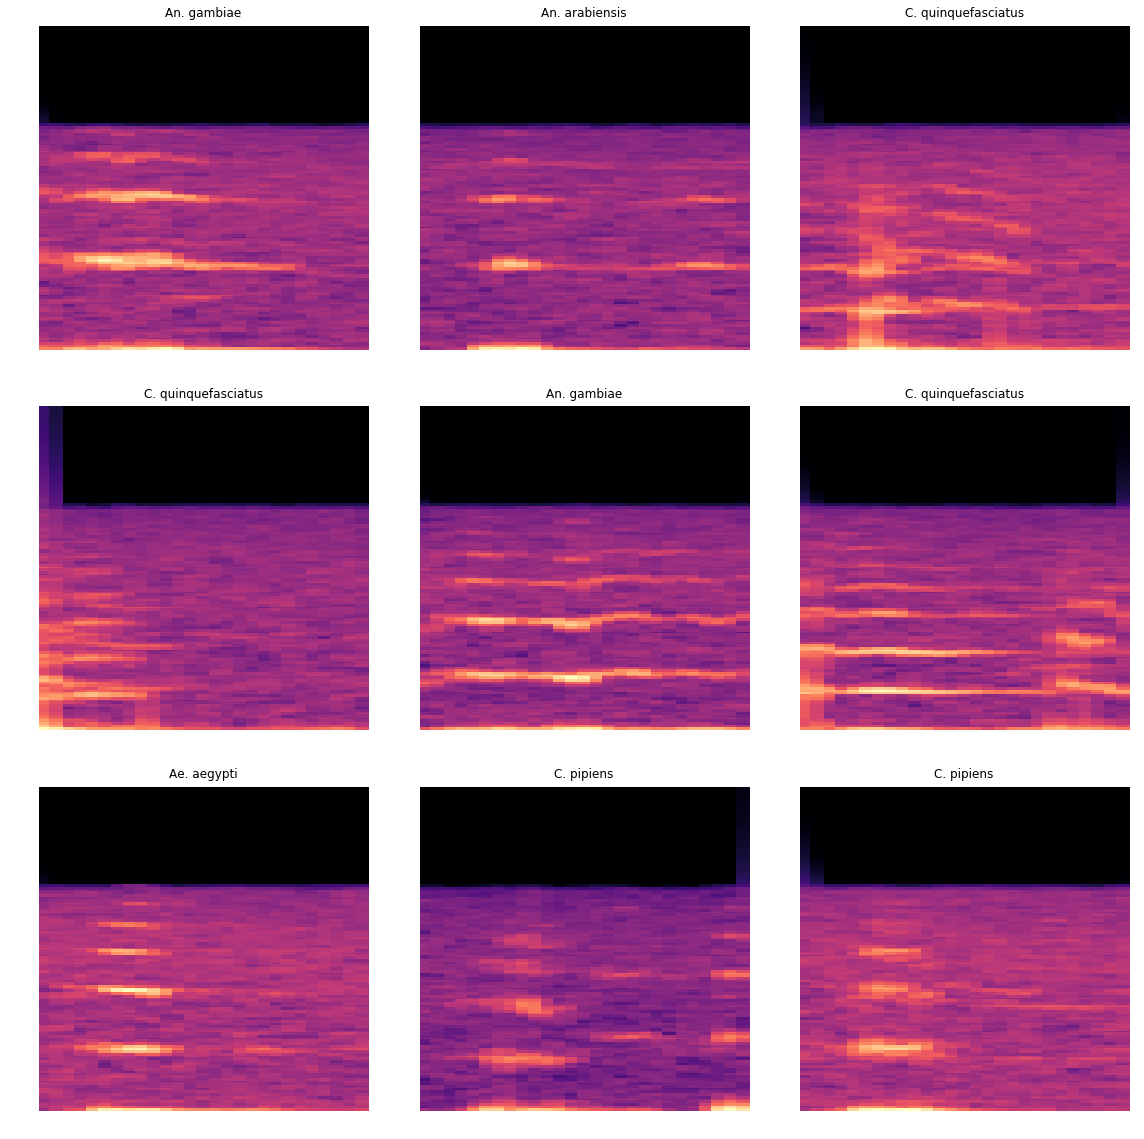

In [11]:
data.show_batch(rows=3, figsize=(16,16))

# Training the ResNet34 model on the spectrograms


In [10]:
def train_model():
    data_directory = Path('Wingbeats/data')
    data = ImageDataBunch.from_folder(data_directory, ds_tfms=[], size=224, bs=12)
    data.normalize(imagenet_stats)
    learn = create_cnn(data, models.resnet34, metrics=accuracy)
    learn.fit_one_cycle(10)
    learn.unfreeze()
    learn.fit_one_cycle(1)
    learn.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))
    learn.recorder.plot_losses()
    interp = ClassificationInterpretation.from_learner(learn)
    interp.plot_confusion_matrix(title='Confusion matrix')

In [ ]:
train_model()

epoch,train_loss,valid_loss,accuracy
1,0.673483,0.893620,0.643319
2,0.478886,0.598825,0.746767
3,0.495506,0.730555,0.681035
4,0.419947,0.622236,0.734914
5,0.347554,0.529374,0.786638
6,0.389310,0.656965,0.723060
7,0.312109,0.551970,0.770474
8,0.306300,0.575775,0.759698
9,0.268458,0.522879,0.771552
10,0.303963,0.555080,0.750000


epoch,train_loss,valid_loss,accuracy
1,0.299483,0.936381,0.788793


epoch,train_loss,valid_loss,accuracy
1,0.271875,0.512170,0.798491
2,0.275629,0.541173,0.779095
3,0.257523,0.574161,0.779095
4,0.254979,0.523761,0.797414
5,0.213632,0.503326,0.795259
6,0.229837,0.495203,0.794181
7,0.230950,0.476815,0.810345
8,0.213163,0.547940,0.780172
9,0.226609,0.476506,0.806035


# Plots and Results

The maximum accuracy obtained is 80.6%

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


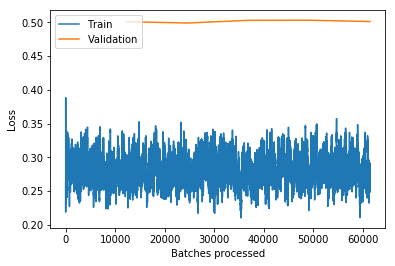

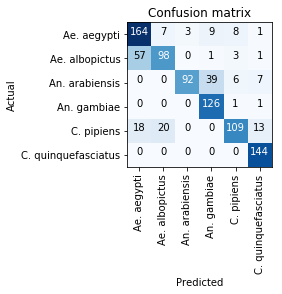

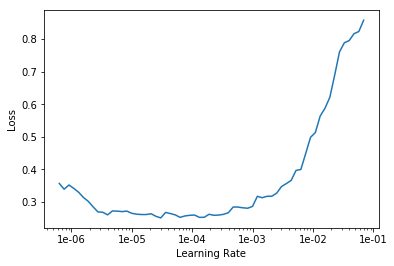

In [11]:
data_directory = Path('Wingbeats/data')
data = ImageDataBunch.from_folder(data_directory, ds_tfms=[], size=224, bs=12)
data.normalize(imagenet_stats)
learn = create_cnn(data, models.resnet34, metrics=accuracy)
learn.fit_one_cycle(5)
learn.unfreeze()
learn.fit_one_cycle(1)
learn.fit_one_cycle(5, max_lr=slice(1e-9,1e-6))
learn.recorder.plot_losses()
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')
learn.lr_find()
learn.recorder.plot()